C:\Users\admin\miniconda3\envs\deepfake-detection\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not load this library: C:\Users\admin\miniconda3\envs\deepfake-detection\Lib\site-packages\torchvision\image.pyd'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [148]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparisons(real, recon=None, mixed=None):
    """
    Plots comparisons:
    - If recon is provided: two rows
        1. Real vs Recon (and Residual)
        2. Real vs Mixed (and Residual)
    - If recon is None: only Real vs Mixed
    """
    real_np = np.array(real).astype(np.float32)

    if recon is not None:
        recon_np = np.array(recon).astype(np.float32)
        resid_recon = np.mean(np.abs(real_np - recon_np), axis=2)
        vmax = np.percentile(resid_recon, 99)
    else:
        vmax = None

    if mixed is not None:
        mixed_np = np.array(mixed).astype(np.float32)
        resid_mixed = np.mean(np.abs(real_np - mixed_np), axis=2)
        if vmax is None:  # if recon not provided, scale from mixed
            vmax = np.percentile(resid_mixed, 99)
    else:
        raise ValueError("Mixed image must be provided")

    if recon is not None:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # --- ROW 1: Recon vs Real ---
        axes[0, 0].imshow(real)
        axes[0, 0].set_title("Original (Real)")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(recon)
        axes[0, 1].set_title("VAE Reconstruction")
        axes[0, 1].axis("off")

        im1 = axes[0, 2].imshow(resid_recon, cmap='inferno', vmin=0, vmax=vmax)
        axes[0, 2].set_title(f"Residual: |Real - Recon|\n(Mean Err: {np.mean(resid_recon):.2f})")
        axes[0, 2].axis("off")
        fig.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)

        # --- ROW 2: Mixed vs Real ---
        axes[1, 0].imshow(real)
        axes[1, 0].set_title("Original (Real)")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(mixed)
        axes[1, 1].set_title("Pixel Mixed")
        axes[1, 1].axis("off")

        im2 = axes[1, 2].imshow(resid_mixed, cmap='inferno', vmin=0, vmax=vmax)
        axes[1, 2].set_title(f"Residual: |Real - Mixed|\n(Mean Err: {np.mean(resid_mixed):.2f})")
        axes[1, 2].axis("off")
        fig.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # --- Single Row: Mixed vs Real ---
        axes[0].imshow(real)
        axes[0].set_title("Original (Real)")
        axes[0].axis("off")

        axes[1].imshow(mixed)
        axes[1].set_title("Pixel Mixed")
        axes[1].axis("off")

        im2 = axes[2].imshow(resid_mixed, cmap='inferno', vmin=0, vmax=vmax)
        axes[2].set_title(f"Residual: |Real - Mixed|\n(Mean Err: {np.mean(resid_mixed):.2f})")
        axes[2].axis("off")
        fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [149]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PairedAugmentation:
    def __init__(self):
        self.transform = A.Compose(
            [
                # Resize if smaller than 224
                A.SmallestMaxSize(max_size=224, p=1),

                # Random crop (applies to both)
                A.RandomCrop(height=224, width=224, p=1),

                # JPEG compression (applies to both)
                A.ImageCompression(quality_lower=50, quality_upper=100, p=1),

                # Gaussian blur (applies to both)
                A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.5, 1), p=1),

                # Horizontal flip (applies to both)
                A.HorizontalFlip(p=0.5),

                # Convert to tensor
                ToTensorV2(transpose_mask=True)
            ],
            additional_targets={
                "pair": "image"   # treat the paired image like another image
            }
        )
        #add image net normalization 
        
    def __call__(self, img, pair_img):
        img,pair = np.array(img), np.array(pair_img)
        
        augmented = self.transform(image=img, pair=pair)
        img_tensor = augmented["image"]
        pair_tensor = augmented["pair"]
        # mix_tensor = torch.cat([img_tensor, pair_tensor], dim=0)
        # return mix_tensor

        return img_tensor, pair_tensor

In [151]:
from pathlib import Path
class Data(torch.utils.data.Dataset):
    def __init__(self,real_dir,recon_dir,patch_crop=224,freq_ratios=(0.0, 0.8),pixel_ratios=(0.5, 1.),seed=42):
        super().__init__()
        self.real_dir = real_dir
        self.recon_dir = recon_dir
        self.real_paths = list(sorted(Path(real_dir).glob("*")))
        self.recon_paths = list(sorted(Path(recon_dir).glob("*")))

        self.freq_mixer = FreqMix(
            ratios=list(freq_ratios),
            random_seed=None
        )

        self.pixel_mixer = PixelBlendMix(
            ratios=list(pixel_ratios),
            random_seed=None
        )

        self.transform = PairedAugmentation()

    def __len__(self):
        return len(self.real_paths)
    def __getitem__(self,i):
        real_img = Image.open(self.real_paths[i]).convert("RGB")
        recon_img = Image.open(self.recon_paths[i]).convert("RGB")
        if random.randint(0,1) == 0:
            mix_img = self.freq_mixer(real_img,recon_img)
        else:
            mix_img = self.pixel_mixer(real_img,recon_img)
        real, mixed = self.transform(real_img,mix_img)
        return real,mixed,0,1
        # return real_img,recon_img,mix_img
        # return self.transform(real_img,recon_img)
            
ds = Data(real_dir=r"E:/data/ImageNet/real_imagenet",recon_dir=r"E:/data/ImageNet/recon")


C:\Users\admin\AppData\Local\Temp\ipykernel_2000\2576590035.py:15: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=50, quality_upper=100, p=1),


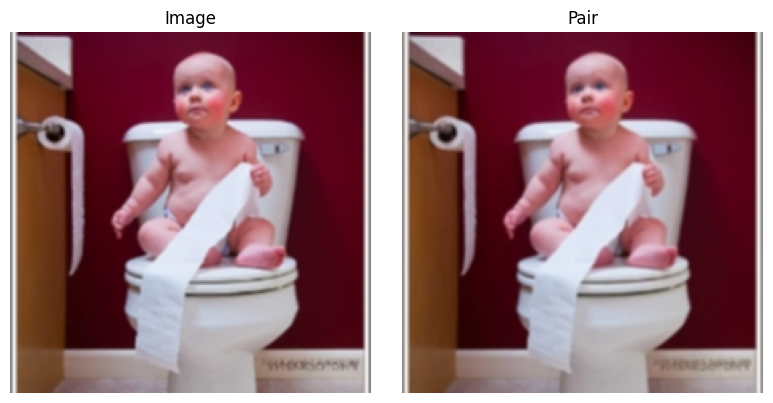

In [152]:
r,f,c,b = ds[-11]
rb,fb= plot_tensors_side_by_side(r,f)

In [153]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image

def plot_tensors_side_by_side(img_tensor, pair_tensor, title1="Image", title2="Pair"):
    """
    Plot image tensor and pair tensor side by side, and return them as PIL images.
    - img_tensor: torch.Tensor of shape (C,H,W)
    - pair_tensor: torch.Tensor of shape (C,H,W)
    """
    # Convert tensors to numpy for plotting
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    pair_np = pair_tensor.permute(1, 2, 0).cpu().numpy()

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_np)
    axes[0].set_title(title1)
    axes[0].axis("off")

    axes[1].imshow(pair_np)
    axes[1].set_title(title2)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Convert tensors to PIL images
    img_pil = to_pil_image(img_tensor.cpu())
    pair_pil = to_pil_image(pair_tensor.cpu())

    return img_pil, pair_pil

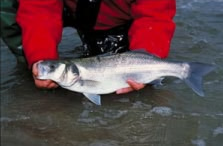

In [26]:
f

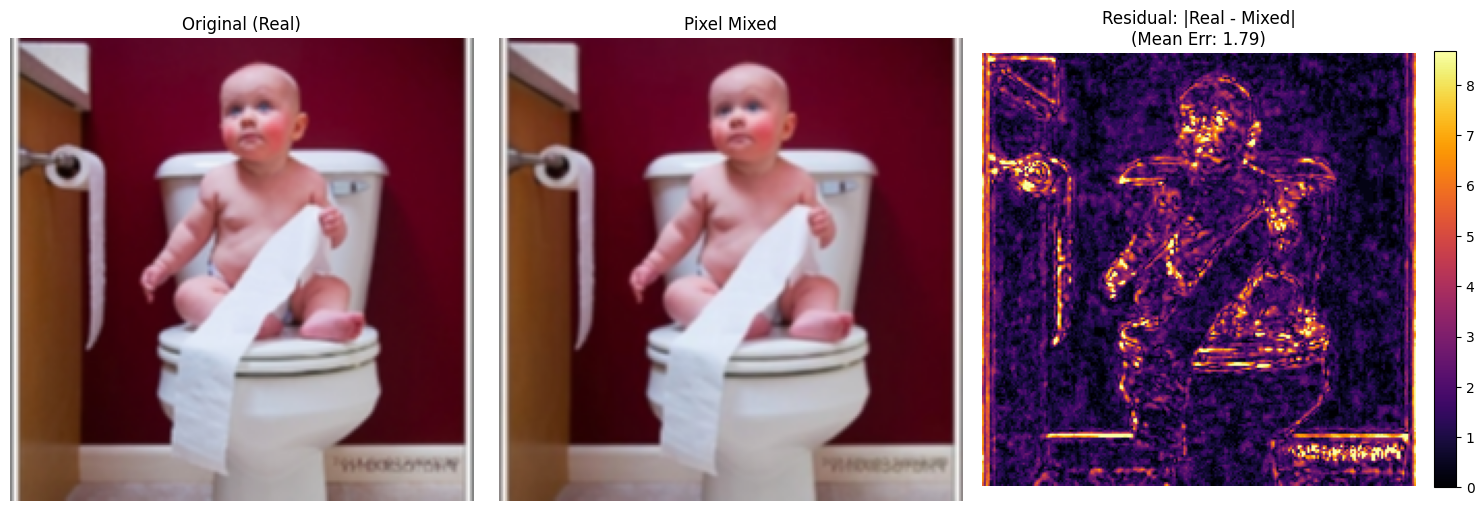

In [154]:
plot_comparisons(rb,mixed=fb)


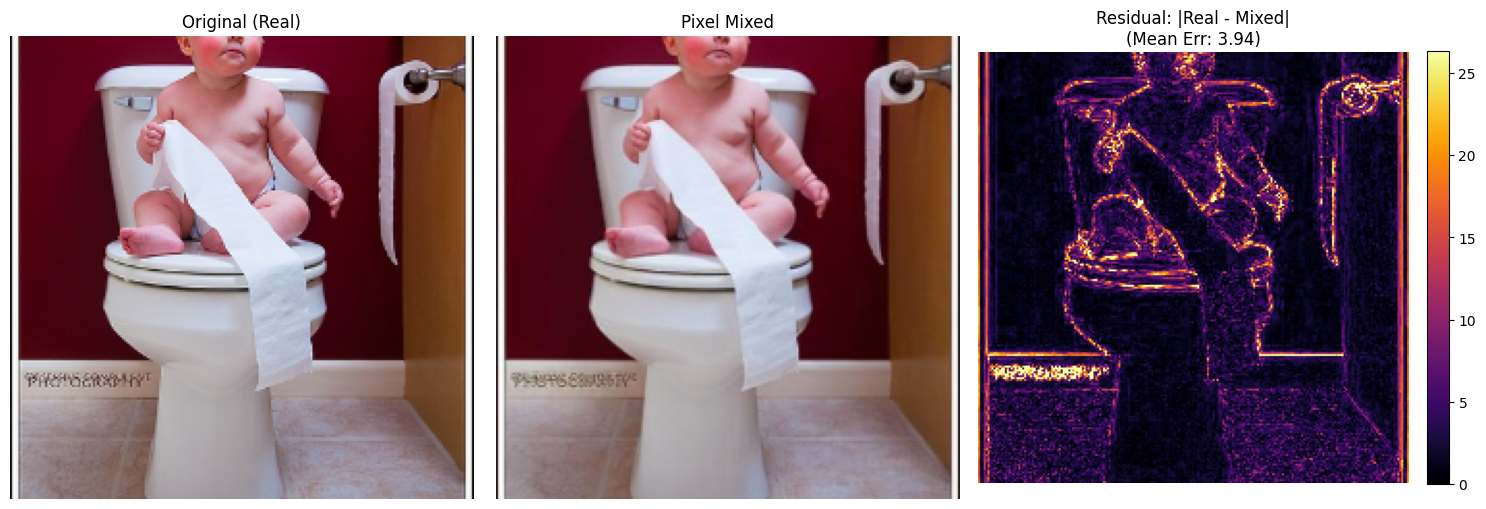

In [146]:
plot_comparisons(rb,mixed=fb)


In [113]:
import torch
import random

def paired_collate_fn(batch):
    """
    batch: list of tuples (img, pair, 0, 1)
    Output: shuffled stacked tensors and labels
    """
    images = []
    labels = []

    for img, pair, lbl_img, lbl_pair in batch:
        # Append both image and pairimage
        images.append(img)
        labels.append(lbl_img)

        images.append(pair)
        labels.append(lbl_pair)

    # Stack into batch tensor
    images = torch.stack(images, dim=0)  # shape: [B, C, H, W]
    labels = torch.tensor(labels)

    # Shuffle consistently
    indices = list(range(len(labels)))
    random.shuffle(indices)

    images = images[indices]
    labels = labels[indices]

    return images, labels

In [114]:
from torch.utils.data import DataLoader

loader = DataLoader(ds, batch_size=16, collate_fn=paired_collate_fn)

for batch_imgs, batch_labels in loader:
    print("Batch images shape:", batch_imgs.shape)  # [batch_size*2, C, H, W]
    print("Batch labels:", batch_labels)
    break

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 1])


tensor([[[[254, 254, 254,  ...,  68,  72,  73],
          [254, 254, 254,  ...,  79,  78,  78],
          [254, 254, 254,  ...,  97,  92,  95],
          ...,
          [ 99, 101, 104,  ...,  34,  31,  30],
          [102, 103, 106,  ...,  36,  34,  33],
          [102, 103, 106,  ...,  37,  35,  34]],

         [[254, 254, 254,  ...,  76,  80,  81],
          [254, 254, 254,  ...,  87,  86,  87],
          [254, 254, 254,  ..., 105, 101, 104],
          ...,
          [ 92,  92,  93,  ...,  36,  33,  31],
          [ 95,  95,  95,  ...,  38,  36,  34],
          [ 95,  95,  96,  ...,  39,  37,  36]],

         [[254, 254, 254,  ...,  77,  86,  89],
          [254, 254, 254,  ...,  89,  91,  93],
          [254, 254, 254,  ..., 107, 104, 108],
          ...,
          [ 76,  78,  81,  ...,  38,  35,  35],
          [ 79,  80,  82,  ...,  39,  37,  36],
          [ 79,  80,  83,  ...,  40,  38,  37]]],


        [[[246, 246, 246,  ...,  69,  54,  54],
          [246, 246, 246,  ...,  59